Task - 04  Develop a hand gesture recognition model that can accurately identify and classify different hand gestures from image or video data, enabling intuitive human-computer interaction and gesture-based control systems.

Dataset :-  https://www.kaggle.com/gti-upm/leapgestrecog

# Intro
The Hand Gesture Recognition Database comprises near-infrared images depicting ten different hand gestures. Within this notebook, we employ end-to-end deep learning techniques to construct a classifier for these images.

Initially, we'll import necessary packages for reading and plotting the images.

In [ ]:
import numpy as np # We'll be storing our data as numpy arrays
import os # For handling directories
from PIL import Image # For handling the images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg # Plotting


As outlined in the Data Overview, there exist 10 folders denoted by 00 to 09, each housing images pertaining to a specific subject. Within each folder, subfolders represent individual gestures. We'll construct a dictionary named lookup to store the names of the gestures requiring identification, assigning a numerical identifier to each gesture. Additionally, we'll create a dictionary named reverselookup to indicate which gesture corresponds to a given identifier.

In [ ]:
lookup = dict()
reverselookup = dict()
count = 0
for j in os.listdir('B:/Hand Gestures/leapGestRecog/00/'):
    if not j.startswith('.'): # If running this code locally, this is to
                            # ensure you aren't reading in hidden folders
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup

{'01_palm': 0,
 '02_l': 1,
 '03_fist': 2,
 '04_fist_moved': 3,
 '05_thumb': 4,
 '06_index': 5,
 '07_ok': 6,
 '08_palm_moved': 7,
 '09_c': 8,
 '10_down': 9}

Next we read in the images, storing them in `x_data`. We store the numerical classifier for each image in `y_data`. Since the images are quite large and are coming from an infra-red sensor, there's nothing really lost in converting them to greyscale and resizing to speed up the computations.

In [ ]:
x_data = []
y_data = []
datacount = 0 # We'll use this to tally how many images are in our dataset
for i in range(0, 10): # Loop over the ten top-level folders
    for j in os.listdir('B:/Hand Gestures/leapGestRecog/0' + str(i) + '/'):
        if not j.startswith('.'): # Again avoid hidden folders
            count = 0 # To tally images of a given gesture
            for k in os.listdir('B:/Hand Gestures/leapGestRecog/0' +
                                str(i) + '/' + j + '/'):
                                # Loop over the images
                img = Image.open('B:/Hand Gestures/leapGestRecog/0' +
                                 str(i) + '/' + j + '/' + k).convert('L')
                                # Read in and convert to greyscale
                img = img.resize((320, 120))
                arr = np.array(img)
                x_data.append(arr)
                count = count + 1
            y_values = np.full((count, 1), lookup[j])
            y_data.append(y_values)
            datacount = datacount + count
x_data = np.array(x_data, dtype = 'float32')
y_data = np.array(y_data)
y_data = y_data.reshape(datacount, 1) # Reshape to be the correct size

Let's take a look at some of the pictures. Since each of the subfolders in 00 contained 200 images, we'll use the following piece of code to load one image of each gesture.

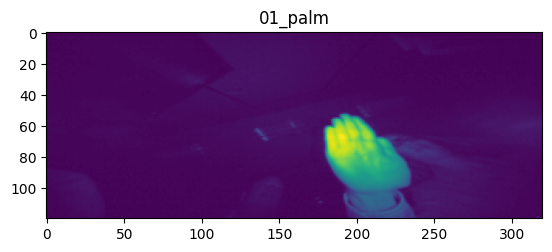

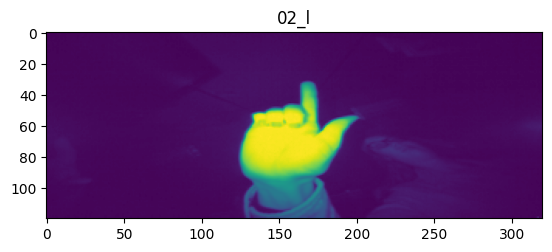

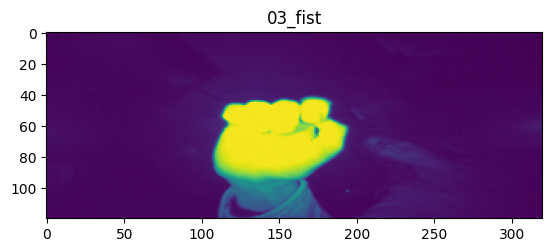

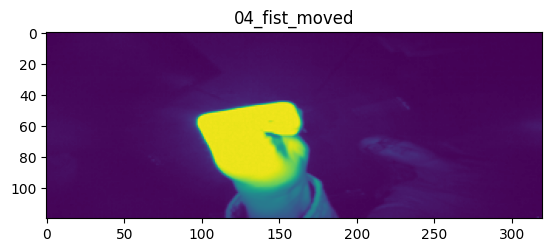

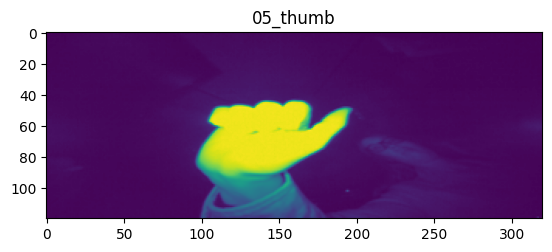

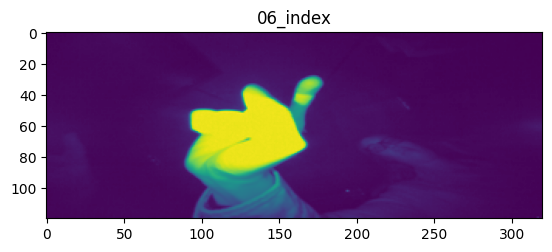

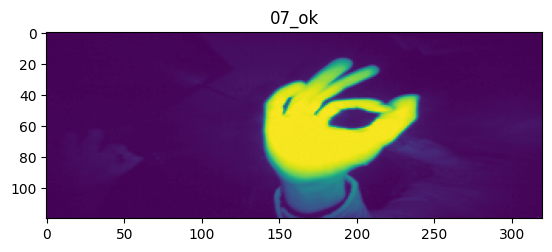

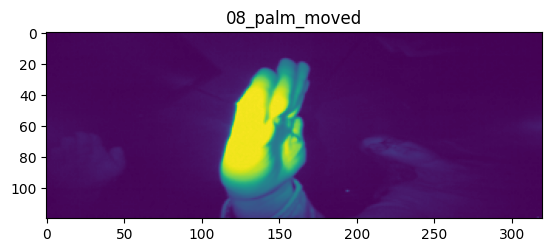

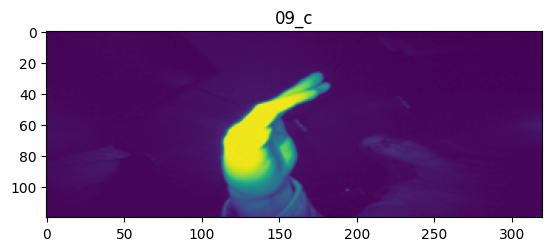

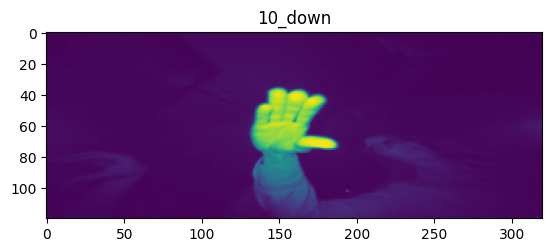

In [ ]:
from random import randint
for i in range(0, 10):
    plt.imshow(x_data[i*200 , :, :])
    plt.title(reverselookup[y_data[i*200 ,0]])
    plt.show()

In [ ]:
import keras
from keras.utils import to_categorical
y_data = to_categorical(y_data)

Our set of images has shape (datacount, 120, 320). Keras will be expecting another slot to tell it the number of channels, so we reshape x_data accordingly. We also rescale the values in x_data to lie between 0 and 1.

In [ ]:
x_data = x_data.reshape((datacount, 120, 320, 1))
x_data /= 255

We need a cross-validation set and a test set, and we'll use the sklearn package to construct these. In order to get an 80-10-10 split, we call train_test_split twice, first to split 80-20, then to split the smaller chunk 50-50. Note that we do this after the rescaling step above, to ensure that our train and test sets are coming from the same distribution.

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_further,y_train,y_further = train_test_split(x_data,y_data,test_size = 0.2)
x_validate,x_test,y_validate,y_test = train_test_split(x_further,y_further,test_size = 0.5)

Now it's time to build our network. We'll use keras.

In [ ]:
from keras import layers
from keras import models

Since our images are big (we chose not to do any cropping) and the classification problem looks quite easy, we're going to downsample fairly aggressively, beginning with a 5 x 5 filter with a stride of 2. Note we have to specify the correct input shape at this initial layer, and keras will figure it out from then on. We won't worry about padding since it's clear that all the useful features are well inside the image. We'll continue with a sequence of convolutional layers followed by max-pooling until we arrive at a small enough image that we can add a fully-connected layer. Since we need to classify between 10 possibilities, we finish with a softmax layer with 10 neurons.

In [ ]:
model=models.Sequential()
model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), activation='relu', input_shape=(120, 320,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

Finally, we fit the model.

In [ ]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10, batch_size=64, verbose=1, validation_data=(x_validate, y_validate))


Epoch 1/10


250/250 [==============================] - 45s 177ms/step - loss: 0.3340 - accuracy: 0.8933 - val_loss: 0.0077 - val_accuracy: 0.9970
Epoch 2/10
250/250 [==============================] - 43s 171ms/step - loss: 0.0129 - accuracy: 0.9962 - val_loss: 0.0030 - val_accuracy: 0.9995
Epoch 3/10
250/250 [==============================] - 42s 167ms/step - loss: 0.0046 - accuracy: 0.9987 - val_loss: 1.5162e-05 - val_accuracy: 1.0000
Epoch 4/10
250/250 [==============================] - 41s 165ms/step - loss: 0.0059 - accuracy: 0.9987 - val_loss: 1.4411e-05 - val_accuracy: 1.0000
Epoch 5/10
250/250 [==============================] - 45s 179ms/step - loss: 5.7171e-04 - accuracy: 0.9998 - val_loss: 1.7329e-05 - val_accuracy: 1.0000
Epoch 6/10
250/250 [==============================] - 43s 170ms/step - loss: 0.0027 - accuracy: 0.9993 - val_loss: 2.4586e-04 - val_accuracy: 1.0000
Epoch 7/10
250/250 [==============================] - 42s 169ms/step - loss: 4.3534e-05 - accuracy: 1.0000 

At this point we would typically graph the accuracy of our model on the validation set, and choose a suitable number of epochs to train for to avoid overfitting. We might also consider introducing dropout and regularisation. However, we can see we're getting perfect accuracy on the validation set after just one or two epochs, so we're pretty much done. Let's quickly confirm that this is carrying through to the test set:

In [ ]:
[loss, acc] = model.evaluate(x_test,y_test,verbose=1)
print("Accuracy:" + str(acc))

63/63 [==============================] - 2s 27ms/step - loss: 0.0070 - accuracy: 0.9990
Accuracy:0.9990000128746033
